Group Members: Asha Karmakar, Akhil Iyer, Megan Sundheim, Grace Kim

In [149]:
import imblearn
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import sklearn as sk
from sklearn.covariance import EllipticEnvelope
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.manifold import MDS
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import LocalOutlierFactor
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

<p> https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features </p>

# TODO: You will want to start with a brief introduction to the problem (utilize markdown cells for this). What is the machine learning problem you are trying to solve? Why does the problem matter? What could the results of your predictive model be used for? Why would we want to be able to predict the thing you’re trying to predict? Then describe the dataset that you will use to tackle this problem.

<h1> Data Preprocessing & Exploration </h1>

# TODO explain what we are doing, why, and whether it worked

In [150]:
# Read in csv file
df = pd.read_csv("./data/genres.csv")

/var/folders/wq/vzy09g8x1bl83rwz73ff6ybh0000gn/T/ipykernel_18603/3599437126.py:2: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./data/genres.csv")


In [151]:
# Clean data
# Remove the following columns: type, id, uri, track_href, analysis_url, unnamed, title, song_name
df = df[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'genre']]

In [152]:
# One hot encode time signature
df = pd.get_dummies(df, columns=['time_signature'], drop_first=False)
df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,genre,time_signature_1,time_signature_3,time_signature_4,time_signature_5
0,0.831,0.814,2,-7.364,1,0.4200,0.059800,0.013400,0.0556,0.3890,156.985,124539,Dark Trap,0,0,1,0
1,0.719,0.493,8,-7.230,1,0.0794,0.401000,0.000000,0.1180,0.1240,115.080,224427,Dark Trap,0,0,1,0
2,0.850,0.893,5,-4.783,1,0.0623,0.013800,0.000004,0.3720,0.0391,218.050,98821,Dark Trap,0,0,1,0
3,0.476,0.781,0,-4.710,1,0.1030,0.023700,0.000000,0.1140,0.1750,186.948,123661,Dark Trap,0,1,0,0
4,0.798,0.624,2,-7.668,1,0.2930,0.217000,0.000000,0.1660,0.5910,147.988,123298,Dark Trap,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42300,0.528,0.693,4,-5.148,1,0.0304,0.031500,0.000345,0.1210,0.3940,150.013,269208,hardstyle,0,0,1,0
42301,0.517,0.768,0,-7.922,0,0.0479,0.022500,0.000018,0.2050,0.3830,149.928,210112,hardstyle,0,0,1,0
42302,0.361,0.821,8,-3.102,1,0.0505,0.026000,0.000242,0.3850,0.1240,154.935,234823,hardstyle,0,0,1,0
42303,0.477,0.921,6,-4.777,0,0.0392,0.000551,0.029600,0.0575,0.4880,150.042,323200,hardstyle,0,0,1,0


In [153]:
# Separate data into features and class labels
features = df.drop('genre', axis=1)
labels = df['genre']

In [154]:
print(features.head())
print()
label_groups = df.groupby('genre')
print(label_groups.size())

   danceability  energy  key  loudness  mode  speechiness  acousticness  \
0         0.831   0.814    2    -7.364     1       0.4200        0.0598   
1         0.719   0.493    8    -7.230     1       0.0794        0.4010   
2         0.850   0.893    5    -4.783     1       0.0623        0.0138   
3         0.476   0.781    0    -4.710     1       0.1030        0.0237   
4         0.798   0.624    2    -7.668     1       0.2930        0.2170   

   instrumentalness  liveness  valence    tempo  duration_ms  \
0          0.013400    0.0556   0.3890  156.985       124539   
1          0.000000    0.1180   0.1240  115.080       224427   
2          0.000004    0.3720   0.0391  218.050        98821   
3          0.000000    0.1140   0.1750  186.948       123661   
4          0.000000    0.1660   0.5910  147.988       123298   

   time_signature_1  time_signature_3  time_signature_4  time_signature_5  
0                 0                 0                 1                 0  
1           

In [155]:
# There are no missing values:
null_data = df[df.isnull().any(axis=1)]
len(null_data)

0

[Text(0.5, 0, 'danceability'),
 Text(1.5, 0, 'energy'),
 Text(2.5, 0, 'key'),
 Text(3.5, 0, 'loudness'),
 Text(4.5, 0, 'mode'),
 Text(5.5, 0, 'speechiness'),
 Text(6.5, 0, 'acousticness'),
 Text(7.5, 0, 'instrumentalness'),
 Text(8.5, 0, 'liveness'),
 Text(9.5, 0, 'valence'),
 Text(10.5, 0, 'tempo'),
 Text(11.5, 0, 'duration_ms'),
 Text(12.5, 0, 'time_signature_1'),
 Text(13.5, 0, 'time_signature_3'),
 Text(14.5, 0, 'time_signature_4'),
 Text(15.5, 0, 'time_signature_5')]

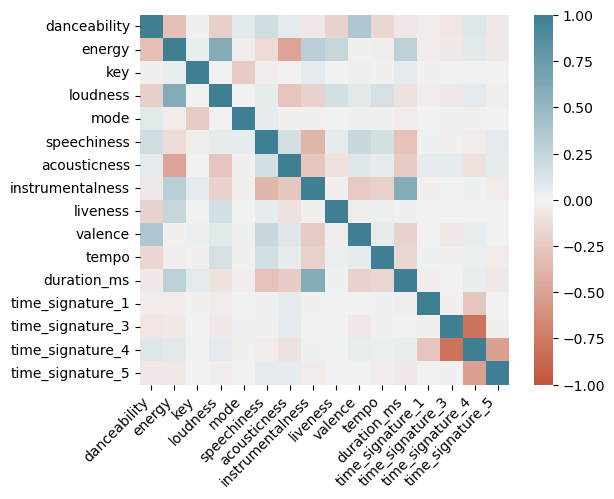

In [156]:
# Plot correlation between features.
ax = sns.heatmap(
    features.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

In [157]:
# Perform anomaly detection.
y_pred_list = []

# Probabilistic anomaly detection.
envelope_pred = EllipticEnvelope().fit_predict(features)
y_pred_list.append(envelope_pred)

# Proximity-based anomaly detection.
forest_pred = IsolationForest().fit_predict(features)
y_pred_list.append(forest_pred)

# Density-based anomaly detection.
lof_pred = LocalOutlierFactor().fit_predict(features)
y_pred_list.append(lof_pred)

y_pred_list

[array([ 1, -1, -1, ...,  1,  1,  1]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([1, 1, 1, ..., 1, 1, 1])]

Counter({1: 38074, -1: 4231})
Counter({1: 37766, -1: 4539})
Counter({1: 40473, -1: 1832})

genre
Dark Trap          3182
Emo                1244
Hiphop             2069
Pop                 364
Rap                1344
RnB                1422
Trap Metal         1411
Underground Rap    4310
dnb                2742
hardstyle          2647
psytrance          2670
techhouse          2799
techno             2479
trance             2743
trap               2689
dtype: int64

Size of new dataset: 34115


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

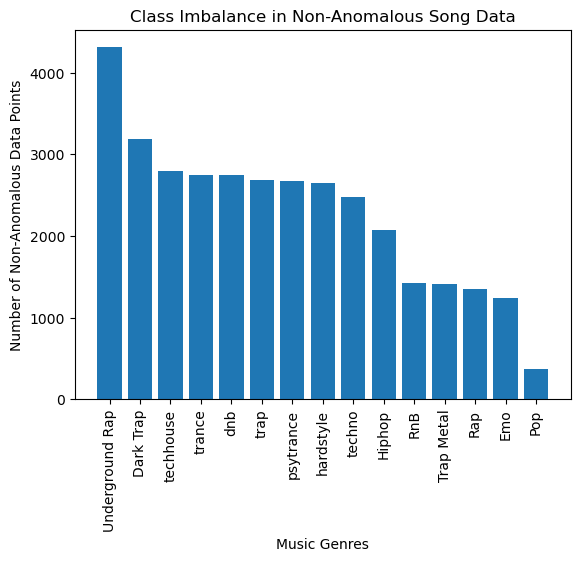

In [158]:
# Drop anomalous points.
from collections import Counter

features_no_anomalies = features.copy()
labels_no_anomalies = labels.copy()
anomaly_indices = set()
for arr in y_pred_list:
    c = Counter(arr)
    print(c)
    i = len(arr) - 1
    while i >= 0:
        if arr[i] == -1:
            anomaly_indices.add(i)
        i -= 1
        
# Drop anomalies indicated by any of the 3 anomaly detection algorithms.
anomaly_indices = list(anomaly_indices)
anomaly_indices.sort()
features_no_anomalies = features_no_anomalies.drop(anomaly_indices, axis=0)
labels_no_anomalies = labels_no_anomalies.drop(anomaly_indices, axis=0)

features_no_anomalies = features_no_anomalies.reset_index().drop('index', axis=1)
labels_no_anomalies = labels_no_anomalies.reset_index().drop('index', axis=1)
label_groups = labels_no_anomalies.groupby('genre')
print()
print(label_groups.size())
print("\nSize of new dataset: %i" % len(features_no_anomalies))

# Display class imbalance with bar graph.
sorted_labels = label_groups.size().sort_values(ascending=False)
sorted_labels = sorted_labels.reset_index()
plt.bar(sorted_labels['genre'], sorted_labels[0])
plt.title('Class Imbalance in Non-Anomalous Song Data')
plt.xlabel('Music Genres')
plt.ylabel('Number of Non-Anomalous Data Points')
plt.xticks(rotation=90)

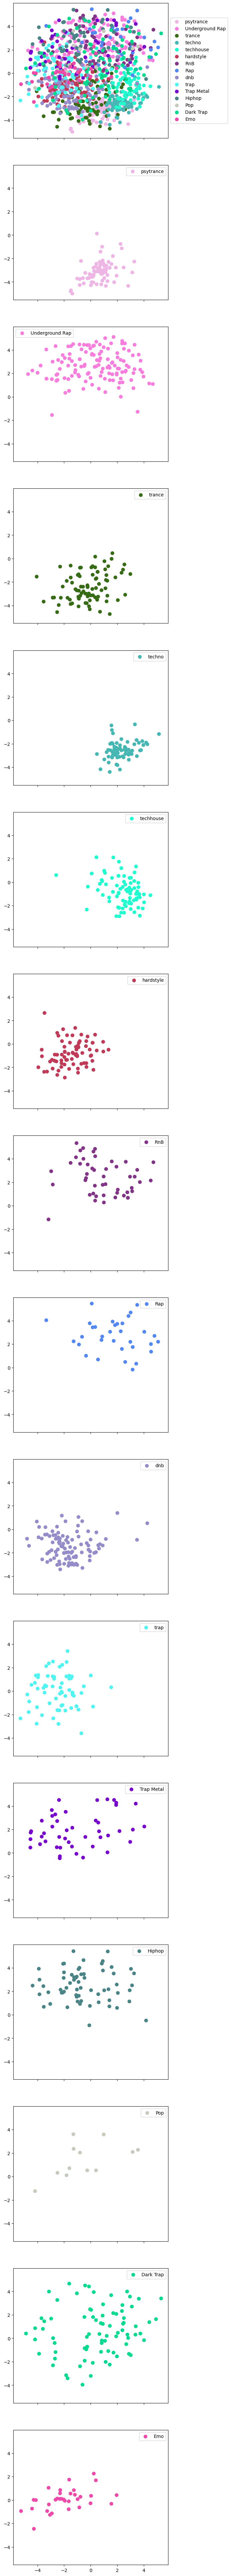

In [159]:
# Modified code from scatter() function from HW 5.
# Print the labeled data clusters after anomalies taken out.

# Scale non-anomalous data.
scaler = sk.preprocessing.StandardScaler()
features_scaled = scaler.fit_transform(features_no_anomalies)
pca = sk.decomposition.PCA(n_components=0.95, svd_solver='full')
features_scaled = pca.fit_transform(features_scaled)

# Sample subset of scaled data points.
numPoints = 1000
numEntries = features_scaled.shape[0]
samp_records = []
samp_labels = []
for i in range(numPoints):
    index = random.randint(0, numEntries - 1)
    samp_records.append(features_scaled[index, :])
    samp_labels.append(labels_no_anomalies.iloc[index, 0])

# Generate different color for each genre.
label_colors = []
color_dict = dict()
for label in samp_labels:
    if not label in color_dict.keys():
        # Originally found in https://stackoverflow.com/questions/28999287/generate-random-colors-rgb.
        color = "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
        color_dict[label] = color
    label_colors.append(color_dict[label])

# Project sampled data down onto 2 dimensions to visualize similarity.
mds = MDS(n_components=2)
mds_data = mds.fit_transform(samp_records)

# Assign label for each data point.
classes = dict()
for i in range(len(mds_data)):
    record = mds_data[i]
    label = samp_labels[i]
    if not label in classes.keys():
        classes[label] = [record]
    else:
        classes[label].append(record)

# Plot cluster of sampled data for each individual genre.
fig, axes = plt.subplots(len(classes.keys()) + 1, 1, figsize=(6, 100), sharey=True, sharex=True)
index = 1
for genre in classes.keys():
    ax = axes[index]
    index += 1
    data = pd.DataFrame(classes[genre])
    color = [color_dict[genre] for i in range(len(data))]
    axes[0].scatter(data.iloc[:, 0], data.iloc[:, 1], c=color, s=50, label=genre)
    ax.scatter(data.iloc[:, 0], data.iloc[:, 1], c=color, s=50, label=genre)

# Originally found in https://towardsdatascience.com/legend-outside-the-plot-matplotlib-5d9c1caa9d31#:~:text=Placing%20the%20legend%20outside%20of%20the%20plot&text=First%2C%20we%20need%20to%20shrink,control%20for%20manual%20legend%20placement.&text=Box%20that%20is%20used%20to,Defaults%20to%20axes.
axes[0].legend(loc='center right', bbox_to_anchor=(1.4, 0.5))
index = 1

# Plot all genres onto one scatterplot.
while index <= len(classes.keys()):
    ax = axes[index]
    ax.legend(loc='best')
    index += 1

In [160]:
# Downsample data to mitigate for class imbalance.
min_size = math.inf
for genre in label_groups.groups.keys():
    genre_group = label_groups.get_group(genre)
    if len(genre_group) < min_size:
        min_size = len(genre_group)
num_samples = min_size

# Sample same number of points from each genre to balance classes.
samp_features = []
samp_genres = []
samp_records = []
df_no_anomalies = pd.DataFrame(features_no_anomalies.copy())
df_no_anomalies['genre'] = labels_no_anomalies
genres = df_no_anomalies.groupby('genre')
for genre in genres.groups.keys():
    genre_group = genres.get_group(genre)
    genre_group_copy = genre_group.copy()
    genre_group_copy = genre_group_copy.reset_index()
    for i in range(num_samples):
        index = random.randint(0, len(genre_group_copy) - 1)
        samp_records.append(genre_group_copy.iloc[index, :])

samp_features = pd.DataFrame(samp_records).set_index('index')
samp_genres = pd.DataFrame(samp_features['genre'])
samp_features = samp_features.drop('genre', axis=1)
print(samp_features)
print(samp_genres)

for genre in classes.keys():
    # Sum WSS over each genre.
    cohesion = 0
    data = df_no_anomalies[df_no_anomalies['genre'] == genre].drop('genre', axis=1)
    centroid = np.mean(data, axis=0)

print("Balanced downsampled labels:")
print(samp_genres.groupby('genre').size())

       danceability  energy  key  loudness  mode  speechiness  acousticness  \
index                                                                         
1423          0.633   0.787    9    -6.815     0       0.0694       0.09880   
2084          0.595   0.471    4   -14.373     0       0.0386       0.00630   
925           0.348   0.925   11    -6.411     0       0.3260       0.00171   
1966          0.610   0.785    6    -7.249     1       0.0429       0.08780   
1630          0.641   0.694    4    -7.497     0       0.0639       0.27200   
...             ...     ...  ...       ...   ...          ...           ...   
26178         0.485   0.986    1    -2.806     1       0.2530       0.00199   
28435         0.668   0.962    9    -1.326     1       0.0754       0.00417   
28245         0.325   0.931    8    -2.960     0       0.1560       0.00340   
27814         0.555   0.956    6    -4.271     0       0.2520       0.00343   
27995         0.328   0.977    6    -0.335     0    

<h1> Model Building </h1>

### Naive Bayes

As part of our group's brainstorming process for which classifier types would be most appropriate to train our data on, we chose to try Naive Bayes since it is not susceptible to the curse of dimensionality (and we have a quite a few features we are using). Since Naive Bayes assumes that all features are conditionally independent of each other given the label and our features were weakly correlated with each other, we thought this was an additional reason this classifier could be appropriate.

Gaussian Naive Bayes was the only subtype of this classifier that we were able to use since it allowed for use of continuous feature values. Multinomial and Categorical required discrete feature values, Complement needed nonnegative values, and Bernoilli relied on binary feature values, so we couldn't use any of these while using all of our features (original and reduced dimensionality).

We first trained 2 different Gaussian Naive Bayes classifiers with 10-fold cross validation for all of our data and 
for our data without the anomalies detected during data exploration and cleaning. This was to determine how much anomalies skewed the classifier's feature probability distributions. 


In [161]:
# Create a Gaussian Naive Bayes classifier.
gnb = GaussianNB()

# Run 10-fold cross validation on classifier.
accuracies = sk.model_selection.cross_val_score(gnb, features, list(labels), cv=10)

# Print the accuracy of the cross-validated model.
avg_accuracy = accuracies.mean()
print("Accuracy:", (avg_accuracy * 100))


# Create a Gaussian Naive Bayes classifier for data without anomalies.
gnb_no_anomalies = GaussianNB()
labels_no_anomalies = labels_no_anomalies.iloc[:, 0]

# Run 10-fold cross validation on classifier for data without anomalies.
accuracies_no_anomalies = sk.model_selection.cross_val_score(gnb_no_anomalies, features_no_anomalies, labels_no_anomalies, cv=10)

# Print the accuracy of the cross-validated model for data without anomalies.
avg_accuracy_no_anomalies = accuracies_no_anomalies.mean()
print("Accuracy without anomalies:", (avg_accuracy_no_anomalies * 100))

Accuracy: 49.334593870637356
Accuracy without anomalies: 52.158858331245405


Given our 15 genres to choose from in classification of a song in the dataset, a random classifier would have about a 6.67% chance of choosing a certain genre. Therefore, with our whole data classifier yielding ~49.3% accuracy and the non-anomalous classifier yielding ~52.3% accuracy, both classifiers performed significantly better than random. 

Also worth noting is the improvement in the accuracy of the classifier by 3% after removing anomalies, indicating that the of the ~8000 points we removed, there was some skewing of classes by anomalous feature values.

Due to the severe class imbalance between genres in this dataset, accuracy may not be an accurate depiction of the spread of classification performance across classes. Therefore, we wanted to take a look at the classification matrix and report of other evaluation metrics to investigate the performance of our classifiers.

In [162]:
# Plot the confusion matrix in a more visually appealing heat map.
def plot_confusion_matrix(confusion_mat):
    ax = plt.subplot()
    sns.heatmap(confusion_mat, annot=True, fmt='g', ax=ax)
    
    unique_labels = sorted(list(set(list(labels))))

    # Labels, title and ticks.
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(unique_labels, rotation=90)
    ax.yaxis.set_ticklabels(unique_labels, rotation=0)


Classification Report with Anomalies:
                  precision    recall  f1-score   support

      Dark Trap       0.32      0.03      0.06      4578
            Emo       0.00      0.00      0.00      1680
         Hiphop       0.36      0.23      0.28      3028
            Pop       0.00      0.00      0.00       461
            Rap       0.50      0.29      0.37      1848
            RnB       0.00      0.00      0.00      2099
     Trap Metal       0.49      0.01      0.03      1956
Underground Rap       0.34      0.65      0.44      5875
            dnb       0.72      0.99      0.83      2966
      hardstyle       0.48      0.90      0.63      2936
      psytrance       0.76      0.92      0.83      2961
      techhouse       0.46      0.76      0.57      2975
         techno       0.68      0.80      0.73      2956
         trance       0.40      0.44      0.42      2999
           trap       0.55      0.48      0.51      2987

       accuracy                           0.49

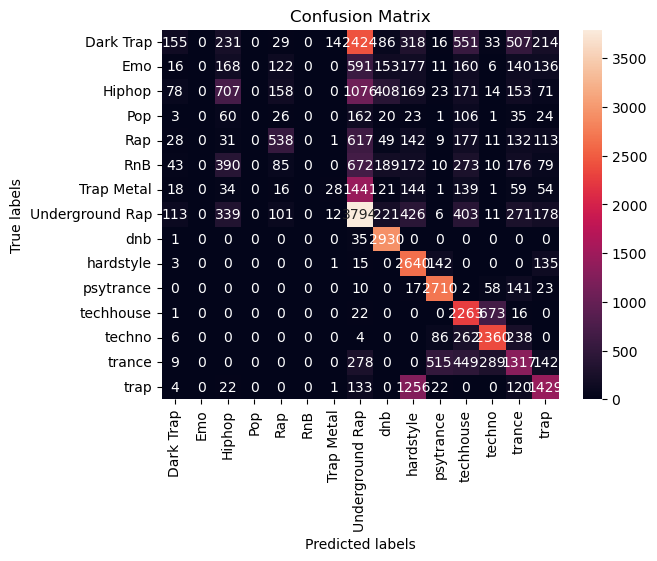

In [163]:
# Original code from Megan Sundheim's HW 4.

# Print the confusion matrix for the whole data classifier.
pred_labels = sk.model_selection.cross_val_predict(gnb, features, labels, cv=10)
con_mat = sk.metrics.confusion_matrix(labels, pred_labels)
plot_confusion_matrix(con_mat)

# Display the classification report for the whole data Naive Bayes classifier.
report = sk.metrics.classification_report(labels, pred_labels, zero_division=0)
print("\nClassification Report with Anomalies:\n", report)


Classification Report without Anomalies:
                  precision    recall  f1-score   support

      Dark Trap       0.23      0.01      0.02      3182
            Emo       0.00      0.00      0.00      1244
         Hiphop       0.36      0.25      0.30      2069
            Pop       0.00      0.00      0.00       364
            Rap       0.47      0.23      0.31      1344
            RnB       0.00      0.00      0.00      1422
     Trap Metal       0.55      0.02      0.04      1411
Underground Rap       0.36      0.61      0.45      4310
            dnb       0.75      0.99      0.85      2742
      hardstyle       0.50      0.89      0.64      2647
      psytrance       0.77      0.92      0.83      2670
      techhouse       0.49      0.77      0.60      2799
         techno       0.67      0.78      0.72      2479
         trance       0.42      0.48      0.45      2743
           trap       0.57      0.51      0.53      2689

       accuracy                           0

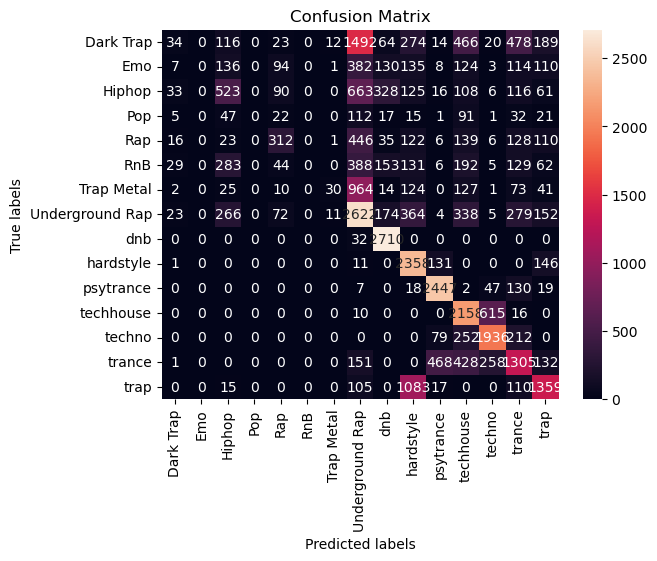

In [164]:
# Original code from Megan Sundheim's HW 4.

# Print the confusion matrix for the classifier without anomalies.
pred_labels_no_anomalies = sk.model_selection.cross_val_predict(gnb_no_anomalies, features_no_anomalies, labels_no_anomalies, cv=10)
con_mat_no_anomalies = sk.metrics.confusion_matrix(labels_no_anomalies, pred_labels_no_anomalies)
plot_confusion_matrix(con_mat_no_anomalies)

# Display the classification report for the Naive Bayes classifier without anomalies.
report_no_anomalies = sk.metrics.classification_report(labels_no_anomalies, pred_labels_no_anomalies, zero_division=0)
report_no_anomalies_dict = sk.metrics.classification_report(labels_no_anomalies, pred_labels_no_anomalies, zero_division=0, output_dict=True)
print("\nClassification Report without Anomalies:\n", report_no_anomalies)

Between the 2 classification reports, both classifiers seem to especially struggle with Emo, Pop, and RnB, having classified 0 songs as these genres, despite more than a 1000 songs in either dataset being Emo and RnB and all of these genres being relatively distinct and recognizable to the human ear. Similarly surprising was the f1 score being unusually low (0.06 with anomalies and 0.02 without) for Dark Trap despite having the 2nd largest amount of songs in this genre in the data. Psytrance and dnb had f1 scores from 0.83-0.85 in either classifier despite a moderate amount of points in each genre.

From these observations, we decided to investigate the relationship between cohesion (with relation to number of points in each genre) of the non-anomalous classes and the f1 scores with Gaussian Naive Bayes. Since Naive Bayes assumes that each feature is independent of each other and relies on probability distributions for each feature, perhaps the so-so performance could be attributed to similar feature values across genres.

Also, due to the variety in f1 scores across imbalanced genres, we decided to try Naive Bayes with a downsampled dataset with non-anomalous data.

In [165]:
rel_cohesion = dict()
df_no_anomalies = pd.DataFrame(features_no_anomalies.copy())
df_no_anomalies['genre'] = labels_no_anomalies

# Calculate the cohesion (similarity) between points in each genre.
for genre in classes.keys():
    # Sum WSS over each genre.
    cohesion = 0
    data = df_no_anomalies[df_no_anomalies['genre'] == genre].drop('genre', axis=1)
    centroid = np.mean(data, axis=0)
    for i in range(0, len(data)):
        # Sum WSS over each data point in current cluster.
        record = data.iloc[i, :]
        cohesion += (math.sqrt(((record[0] - centroid[0]) ** 2) + (record[1] - centroid[1]) ** 2)) ** 2
    print("The cohesion of records in %s is %f." % (genre, cohesion))
    print("The cohesion of records in %s, relative to size, is %f.\n" % (genre, (cohesion / len(data))))
    rel_cohesion[genre] = cohesion / len(data)
    
# Sum WSS over all genres.
total_cohesion = 0
total_c = np.mean(features_no_anomalies, axis=0)
for i in range(len(features_no_anomalies)):
    record = features_no_anomalies.iloc[i, :]
    total_cohesion += (math.sqrt(((record[0] - total_c[0]) ** 2) + (record[1] - total_c[1]) ** 2)) ** 2

rel_total = total_cohesion / len(features_no_anomalies)
print("The cohesion of all records is %f." % (total_cohesion))
print("The relative cohesion of all records is %f." % (rel_total))

The cohesion of records in psytrance is 43.032122.
The cohesion of records in psytrance, relative to size, is 0.016117.

The cohesion of records in Underground Rap is 151.204883.
The cohesion of records in Underground Rap, relative to size, is 0.035082.

The cohesion of records in trance is 56.346286.
The cohesion of records in trance, relative to size, is 0.020542.

The cohesion of records in techno is 58.941315.
The cohesion of records in techno, relative to size, is 0.023776.

The cohesion of records in techhouse is 61.546434.
The cohesion of records in techhouse, relative to size, is 0.021989.

The cohesion of records in hardstyle is 43.215761.
The cohesion of records in hardstyle, relative to size, is 0.016326.

The cohesion of records in RnB is 50.521448.
The cohesion of records in RnB, relative to size, is 0.035528.

The cohesion of records in Rap is 39.841301.
The cohesion of records in Rap, relative to size, is 0.029644.

The cohesion of records in dnb is 55.326041.
The cohesi

In [166]:
# Compute the correlation between Naive Bayes f1 score and relative cohesion of class for non-anomalous data.
genre_f1 = dict()
genres = df.groupby('genre').groups.keys()
corr_df = []
for genre in genres:
    metrics = report_no_anomalies_dict[genre]
    f1 = metrics['f1-score']
    corr_df.append([f1, rel_cohesion[genre]])

corr_df = pd.DataFrame(corr_df, index=genres, columns=['f1-score', 'Relative Cohesion'])
print(corr_df.corr())

                   f1-score  Relative Cohesion
f1-score           1.000000          -0.788611
Relative Cohesion -0.788611           1.000000


The f1 score from Naive Bayes classification and relative cohesion (without anomalies) of each genre appears to be moderately to highly negatively correlated. Cohesion measures the proximity of each point in a cluster to its centroid, so lower cohesion of songs within their actual genres means that songs are more similar to each other. F1 score combines the precision and recall metrics of classification so that a score of 0 is the worst performance and 1 is the best. Therefore, it makes sense for our performance metric f1 score to be negatively correlated to cohesion, as our classifier should have an easier time discerning between genres (higher f1 score) when songs in a genre tend to be more similar to each other (lower cohesion).

Therefore, the performance of our Naive Bayes classifier seems to be moderately to highly influenced by the similarity of songs within a genre.

We will lastly train a Gaussian Naive Bayes classifier to determine the effect of class imbalance on the classifier's performance.

Accuracy with Sampled/Balanced Non-Anomalous Data: 46.46520146520147

Classification Report with Sampled/Balanced Non-Anomalous Data:
                  precision    recall  f1-score   support

      Dark Trap       0.42      0.01      0.03       364
            Emo       0.32      0.26      0.29       364
         Hiphop       0.32      0.25      0.28       364
            Pop       0.42      0.09      0.14       364
            Rap       0.36      0.34      0.35       364
            RnB       0.17      0.01      0.03       364
     Trap Metal       0.37      0.60      0.46       364
Underground Rap       0.29      0.12      0.16       364
            dnb       0.67      0.99      0.80       364
      hardstyle       0.45      0.89      0.60       364
      psytrance       0.76      0.90      0.82       364
      techhouse       0.38      0.75      0.50       364
         techno       0.67      0.82      0.74       364
         trance       0.36      0.46      0.40       364
         

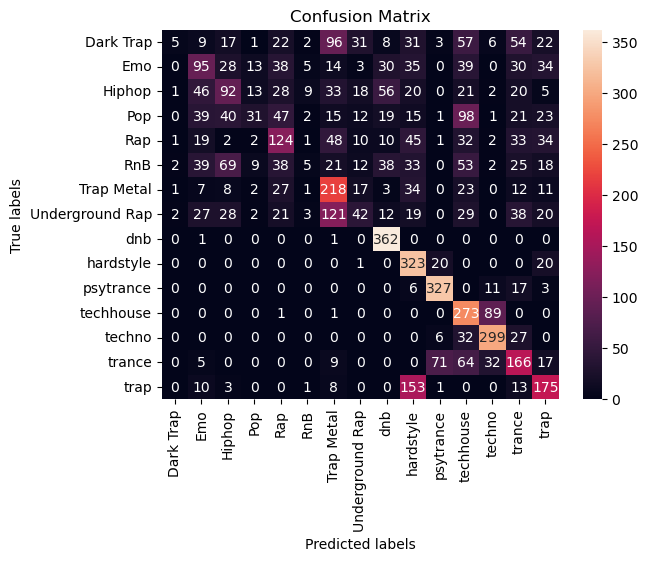

In [167]:
# Run Naive Bayes on sampled data.
gnb_sampled = GaussianNB()

# Run 10-fold cross validation on classifier.
accuracies = sk.model_selection.cross_val_score(gnb_sampled, samp_features, samp_genres.iloc[:, 0], cv=10)

# Print the accuracy of the cross-validated model.
avg_accuracy = accuracies.mean()
print("Accuracy with Sampled/Balanced Non-Anomalous Data:", (avg_accuracy * 100))


# Original code from Megan Sundheim's HW 4.

# Print the confusion matrix for the classifier with balanced classes.
pred_labels_sampled = sk.model_selection.cross_val_predict(gnb_sampled, samp_features, samp_genres.iloc[:, 0], cv=10)
con_mat_sampled = sk.metrics.confusion_matrix(samp_genres, pred_labels_sampled)
plot_confusion_matrix(con_mat_sampled)

# Display the classification report for the Naive Bayes classifier with balanced classes.
report_sampled = sk.metrics.classification_report(samp_genres, pred_labels_sampled, zero_division=0)
print("\nClassification Report with Sampled/Balanced Non-Anomalous Data:\n", report_sampled)

Using the completely balanced downsampled non-anomalous data, the accuracy of our classifer decreased by ~3% and ~6% from our whole data and non-anomalous classifiers, respectively. Although the accuracy decreased, this may actually indicate a more honest and fair representation of the classifier's performance on the dataset.


Notably, all genres receive some number of correct predictions (as opposed to Emo, Pop, and Rnb receiving no predictions in the previous two classifiers). Psytrance and dnb still remain as the best performing classes (f1 scores of 0.82 and 0.80, respectively), however Underground Rap saw a huge hit in its performance (a drop of ~0.30). This genre had the most songs in it originally, perhaps indicating a skew in genre performance based on number of points available in the dataset. 

Overall, the best performing Naive Bayes classifier was most likely the non-anomalous, imbalanced classifier (with the highest weighted precision, recall, and f1 score overall). However, after balancing the data via downsampling, the imbalanced classifier may have been skewed to improve accuracy in majority classes and ignore minority classes in its training.

### Neural Networks

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.20, random_state=4)

scaler = StandardScaler()
pca = PCA()
mlp = MLPClassifier(random_state=1, early_stopping=True)

mlp_param = {
    'mlp__hidden_layer_sizes': list(range(90, 110, 10)),
    'mlp__activation': ('logistic', 'tanh', 'relu'),
    'mlp__solver': ('sgd','adam')
}

mlp_pipe = Pipeline([('scaler', scaler), ('pca', pca), ('mlp', mlp)])
clf = GridSearchCV(mlp_pipe, mlp_param, n_jobs=-1, cv=5)
clf.fit(x_train, y_train) # X is train samples and y is the corresponding labels

In [ ]:
print('Best parameters found:\n', clf.best_params_)

In [ ]:
y_true, y_pred = y_test , clf.predict(x_test)
from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

In [ ]:
from sklearn import metrics
import seaborn as sn

cm=metrics.confusion_matrix(y_test,y_pred)
plt.figure(figsize = (10,7))
sn.set(font_scale=1.2)
sn.heatmap(cm, annot=True, fmt='g')

#df_cm = pd.DataFrame(cm, index = [i for i in "ABCDEFGHIJK"], columns = [i for i in ]

In [ ]:
scaler = StandardScaler()
mlp = MLPClassifier(random_state=1, early_stopping=True, verbose=True)

mlp_param = {
    'mlp__hidden_layer_sizes': list(range(13,15,1)),
    'mlp__solver': ('sgd', 'lbfgs', 'adam')
}

mlp_pipe = Pipeline([('scaler', scaler), ('mlp', mlp)])
mlp_grid = GridSearchCV(mlp_pipe, mlp_param, cv=2)
avg_acc = np.mean(cross_val_score(mlp_grid, features, labels, cv=2))
mlp.fit(features, labels)
print("Accuracy score: ", avg_acc)

### Decision Trees

In [ ]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
from collections import Counter

import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [ ]:
def decision_tree_clf(features, labels):
    dt_model = tree.DecisionTreeClassifier()
    parameters = {'criterion':["gini", "entropy"], 'max_depth':[5, 10, 15, 20], 'min_samples_leaf':[5, 10, 15, 20], 'max_features': [5, 10, 15]}
    dt_grid = GridSearchCV(dt_model, parameters, scoring="accuracy", cv=10)
    dt_grid.fit(features, labels)
    
    best_params = dt_grid.best_params_
    
    dt_model = tree.DecisionTreeClassifier(criterion=best_params.get("criterion"), max_depth=best_params.get("max_depth"), min_samples_leaf=best_params.get("min_samples_leaf"), max_features=best_params.get("max_features"))
    
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    dt_model = dt_model.fit(X_train, y_train)
    y_pred = dt_model.predict(X_test)
    
    print(classification_report(y_test, y_pred))
    
    confusion_mat = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(confusion_mat)

#### Deleting Anomalies

In [ ]:
# With anomalies
decision_tree_clf(features, labels)

# Without anomalies
decision_tree_clf(features_no_anomalies, labels_no_anomalies)

#### Analysis
From the classification report, the hyperparameter tuned decision tree performs well on certain genre such as Underground Rap, dnb, hardstyle, psytrance

trance, and trap. These generes are genres that had high precision, recall, and f1-score which reflects both precision and recall.

#### Using SMOTE

In [ ]:
# Using SMOTE on data without anomalies to balance data.
clf = tree.DecisionTreeClassifier()
smote = imblearn.over_sampling.SMOTE()

In [ ]:
clf_pipeline = imblearn.pipeline.Pipeline(
    steps=[('smote', smote), ('tree', clf)])

param_grid = {
    'smote__sampling_strategy': ['minority', 'not minority', 'not majority', 'all', 'auto'],
    'smote__k_neighbors': range(1, 11),
    'tree__criterion': ['gini', 'entropy'],
    'tree__max_depth': [5, 10, 15, 20],
    'tree__min_samples_leaf': [5, 10, 15, 20],
    'tree__max_features': [5, 10, 15]
}

# Create GridSearchCV object from pipeline and param_grid, and set to 10-fold CV.
grid_search = sk.model_selection.GridSearchCV(clf_pipeline, param_grid, cv=10)

# Fit GridSearchCV to training data.
grid_search.fit(features_no_anomalies, labels_no_anomalies)

# Show best values for hyperparameters.
print("Best hyperparameter values:", grid_search.best_params_)

# Print the accuracy when using best values for hyperparameters.
print("Accuracy with best values:", (grid_search.best_score_ * 100))


# Pass Pipeline into 10 fold nested CV.
nested_accuracies = sk.model_selection.cross_val_score(
    grid_search, features_no_anomalies, labels_no_anomalies, cv=10)

# Print the accuracy of tuned, cross-validated model.
avg_accuracy = nested_accuracies.mean()
print("Accuracy:", (avg_accuracy * 100))

### Random Forest

In [ ]:
def random_forest_clf(features, labels):
    rf_model = RandomForestClassifier()
    rf_param = {'n_estimators': list(range(50, 150, 50))}
    
    rf_param = GridSearchCV(rf_model, rf_param, scoring="accuracy", cv=10)
    rf_param.fit(features, labels)
    
    best_params = rf_param.best_params_
    
    rf_model = RandomForestClassifier(n_estimators=best_params.get("n_estimators"))
    
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    rf_model = rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    
    print(classification_report(y_test, y_pred))
    
    confusion_mat = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(confusion_mat)
    
    # Importance of features
    importances = rf_model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)
    forest_importances = pd.Series(importances, index=list(features.columns))

    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()

In [ ]:
random_forest_clf(features, labels)
random_forest_clf(features_no_anomalies, labels_no_anomalies)

### Cohesion and Separation
#### Cohesion

In [ ]:
rel_cohesion

In [ ]:
x = list(rel_cohesion.keys())
y = list(rel_cohesion.values())

# Create the bar plot
plt.bar(x, y)

# Add labels and title
plt.xticks(rotation=90)
plt.ylabel('Cohesion')
plt.title('Cohesion for each genre')

# Show the plot
plt.show()

#### Separation

In [ ]:
overall_centroid = np.mean(features, axis=0)
overall_centroid
unique_labels = sorted(list(set(list(labels))))

In [ ]:
separation_stats = dict()

centroid_dict = dict()

for genre in unique_labels:
    data = df[df['genre'] == genre].drop('genre', axis=1)
    
    centroid_dict[genre] = np.mean(data, axis=0)
    
    crnt_centroid = np.mean(data, axis=0)
    dist = math.dist(overall_centroid, crnt_centroid) ** 2
    
    data_size = len(data)
    
    bss = dist * data_size
    
    print(genre)
    print(bss)
    
    separation_stats[genre] = bss
    
x = list(separation_stats.keys())
y = list(separation_stats.values())

# Create the bar plot
plt.bar(x, y)

# Add labels and title
plt.xticks(rotation=90)
plt.ylabel('Separation')
plt.title('Separation for each genre')

# Show the plot
plt.show()

### KNN

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

param_grid = {
    'pca__n_components': list(range(5, 16)),
    'knn__n_neighbors': list(range(1, 25))
}


knn_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA()), ('knn', KNeighborsClassifier())])

knn_gscv = GridSearchCV(estimator=knn_pipe, param_grid=param_grid, scoring='accuracy', cv=5)

knn_gscv.fit(features, labels)

print("GridSearchCV Best Params: ", knn_gscv.best_params_)
print("GridSearchCV Best Score", knn_gscv.best_score_)

### K-Means

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import MDS

kmeans = KMeans(n_clusters=15)
kpred = kmeans.fit_predict(music_data_pca)
sil_score = silhouette_score(music_data_pca, kpred, metric='euclidean')

print (sil_score)

In [ ]:
import numpy as np
from math import e
import pandas as pd   

""" Usage: pandas_entropy(df['column1']) """

# Based on StackOverflow post: https://stackoverflow.com/questions/49685591/how-to-find-the-entropy-of-each-column-of-data-set-by-python
def pandas_gini(column, base=None):
    vc = pd.Series(column).value_counts(sort=False)
    base = e if base is None else base
    return 1 - (np.square((vc / len(column)))).sum()

entropies = []
cluster_labels = []
cluster_names = []

for k in range(0, 15):

    filtered_cluster = labels[kpred == k]

    lbl = filtered_cluster.value_counts(sort=False).argmax()
    genre_cf = filtered_cluster.mode()
    cluster_labels.append(lbl)
    cluster_names.append(genre_cf.values[0])

    entropies.append(pandas_gini(filtered_cluster, base=e))

print(cluster_names)
print(cluster_labels)
print(entropies)

In [ ]:
colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(15)]

for k in range(0, 15):

    filtered_label0 = music_data_pca[kpred == k]
    
    color = colors[k]

    mds = MDS(n_components=2)
    mds_data = mds.fit_transform(filtered_label0)
    plt.scatter(mds_data[:,0] , mds_data[:,1], c=color)
    plt.show()

plt.show()

In [ ]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, cophenet

centers = kmeans.cluster_centers_

proximity_matrix = pdist(centers)
methods = ['single', 'complete', 'average', 'centroid', 'ward']
cpccs = []
# the rest of your code goes here

# Compute correlation for every linkage method and get the method with highest corr
for method in methods:
    link_matrix = linkage(centers, method)
    cpcc, _ = cophenet(link_matrix, proximity_matrix)
    cpccs.append(cpcc)

print ("The ", methods[np.argmax(cpccs)], "method worked best since it had the highest CPCC of", np.amax(cpccs))

In [ ]:
hier = linkage(centers, 'average')
plt.figure()
dn = dendrogram(hier)
plt.show()

In [ ]:
# Code adapted from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

n_clusters = 15
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(music_data_pca) + (n_clusters + 1) * 10])

# kpred2 = KMeans(n_clusters=2).fit_predict(music_data_pca)

avg_sil_score = silhouette_score(music_data_pca, kpred, metric='euclidean')
sample_silhouette_values = silhouette_samples(music_data_pca, kpred)

# avg_sil_score = silhouette_score(music_data_pca, kpred, metric='euclidean')
# sample_silhouette_values = silhouette_samples(music_data_pca, kpred)

y_lower = 10
for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[kpred == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )
    
# Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=avg_sil_score, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In [ ]:
kmeans_sil_scores = []
for i in range(2, 16):
    ith_kmeans = KMeans(n_clusters=i)
    ith_kpred = ith_kmeans.fit_predict(music_data_pca)
    ith_sil_score = silhouette_score(music_data_pca, ith_kpred, metric='euclidean')
    kmeans_sil_scores.append(ith_sil_score)

print ("Best K for K-Means Clustering: ", np.argmax(kmeans_sil_scores) + 2)
print ("Highest silhouette score", np.amax(kmeans_sil_scores))

In [ ]:
print ("Best K for K-Means Clustering: ", np.argmax(kmeans_sil_scores) + 2)
print ("Highest silhouette score", np.amax(kmeans_sil_scores))

print (kmeans_sil_scores)

In [ ]:
for i in range(16, 31):
    ith_kmeans = KMeans(n_clusters=i)
    ith_kpred = ith_kmeans.fit_predict(music_data_pca)
    ith_sil_score = silhouette_score(music_data_pca, ith_kpred, metric='euclidean')
    kmeans_sil_scores.append(ith_sil_score)

print (kmeans_sil_scores)

In [ ]:
print ("Best K for K-Means Clustering: ", np.argmax(kmeans_sil_scores) + 2)
print ("Highest silhouette score", np.amax(kmeans_sil_scores))

In [ ]:
# Adapting K-Means for Supervised Clustering Algorithm

# def super_kmeans(train_set: pd.DataFrame, labels):

pca_df = pd.concat([music_data_pca, labels], axis = 1)
group_labels = df.groupby('genre')
all_genres = set(df['genre'].tolist())

# scaled_data = StandardScaler().fit_transform(features.values)
# music_data_scaled = pd.DataFrame(scaled_data, columns=features.columns)

# pca = PCA(n_components=0.95, svd_solver='full')
# pca_data = pca.fit_transform(music_data_scaled)
# music_data_pca = pd.DataFrame(pca_data)
# music_data_pca.head()

all_centroids = []

for genre in all_genres:
    cur_group = pca_df.get_group(genre)

    # scaled_group = pd.DataFrame(StandardScaler().fit_transform(features.values))
    # pca_group = pd.DataFrame(PCA(n_components=0.95, svd_solver='full').fit_transform(scaled_group))
    
    cur_kmeans = KMeans(n_clusters=5)
    kpred_genre = cur_kmeans.fit_predict(cur_group)
    for centroid in cur_kmeans.cluster_centers_:
        all_centroids.append(centroid)

In [ ]:
"""TODO roc curves for each classifier, 
test with anomalies vs. no anomalies, imbalanced vs balanced, 
fix todos and imports, write ups, pretty con mats"""